In [7]:
import os

import numpy as np
import torch
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.utils import data
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from torchmetrics.clustering import CompletenessScore
from torchmetrics import Accuracy
import wandb
from torchvision.datasets import CIFAR10
from torchvision.transforms import v2
from torch.utils.data import random_split, DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import hydra
from omegaconf import DictConfig, OmegaConf
import lightning as L
import pandas as pd

In [8]:
from hydra import compose, initialize
from omegaconf import OmegaConf

from my_lit_model import LitMyModuleManual
from my_dataset import get_dataset
from helpers.transformer import transform_train, transform_test, transform_target

In [3]:
trainer = L.Trainer(devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/scratch/tri/venvs/pytorch12/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [4]:
with initialize(version_base=None, config_path="conf"):
    conf = compose(config_name="config_our_reg.yaml", overrides=["data=cifar10n", "root=/scratch/tri/shahana_outlier"])

print(OmegaConf.to_yaml(conf))

/scratch/tri/venvs/pytorch12/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config_our_reg.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


data:
  'N': 47500
  M: 3
  K: 10
  dataset: cifar10n
train:
  lr: 0.001
  batch_size: 512
  lam1: 0.01
  lam2: 0.01
  num_epochs: 150
  name: reg_version
  plot_confusion_matrix: false
  voltype: f
  confusion_init_type: 1
tags:
- our_reg
root: /scratch/tri/shahana_outlier
debug: false
with_ray: false



In [5]:
best_model_path = '/scratch/tri/shahana_outlier/lightning_saved_models/divine-bush-1156/syn-epoch=168-global_step=0.ckpt'
model = LitMyModuleManual.load_from_checkpoint(best_model_path, N=47500, M=3, K=10, lr=1, 
                                         lam1=1e-2, lam2=1e-2, conf=conf)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/tri/shahana_outlier/lightning_saved_models/divine-bush-1156/syn-epoch=168-global_step=0.ckpt'

In [13]:
data_module = get_dataset(conf)
data_module.setup('pred')
# train_set = next(iter(data_module.train_dataloader()))

Done SETTING data module for CIFAR10-N!


In [14]:
tmp = DataLoader(data_module.train_set, shuffle=False, batch_size=len(data_module.train_set))
train_set = next(iter(tmp))

In [15]:
train_set[0].shape

torch.Size([47500, 3, 32, 32])

In [ ]:
E = model.model.get_e()
E.shape

In [ ]:
err = (E**2).sum((1, 2)).detach().cpu().numpy()
# err = (((E**2).sum((1, 2)))**0.2).detach().cpu().numpy()

In [ ]:
err.min(), err.max()

In [ ]:
inds = np.argsort(err)

In [ ]:
err[inds[:10]], err[inds[-10:]], 

In [ ]:
# v, inds = torch.topk(err, 512)
# inds = inds.detach().cpu().numpy()

In [16]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

In [17]:
to_image = ToPILImage()

In [18]:

# ax = [plt.subplot(2,2,i+1) for i in range(4)]

# for a in ax:
#     a.set_xticklabels([])
#     a.set_yticklabels([])

# plt.subplots_adjust(wspace=0, hspace=0)

In [19]:
big_image_row1 = torch.concat((train_set[0][0], train_set[0][1]), axis=1)
big_image_row2 = torch.concat((train_set[0][2], train_set[0][3]), axis=1)
big_image = torch.concat((big_image_row1, big_image_row2), axis=2)

In [ ]:
# plt.figure(figsize=(10, 10))
# plt.imshow(to_image(big_image))
# plt.show()

In [ ]:
train_set[0][rand_inds[j*5+i]].shape

In [ ]:
sns.set_style("dark")
plt.figure(figsize=(5, 3.))
sns.set(font_scale=2, rc={'text.usetex' : True})
ax = sns.histplot(err, kde=True, bins=10)
ax.ticklabel_format(style='scientific', useMathText=True, scilimits=(0, 0), axis='y')
plt.savefig("cifar10_hist.pdf")

In [ ]:
plt.hist(err, )

In [40]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})


In [35]:
err = np.zeros(train_set[0].shape[0])
err[[2928, 30883, 11953, 21925, 47091]] = [5.09e-3, 5.07e-3, 4.0e-3, 4.97e-3, 4.4e-3]
err[[13598, 46433, 27421, 11588, 45245]] = [5.01e-3, 5.21e-3, 5.36e-3, 5.35e-3, 5.24e-3]
err[[9732, 3215, 8306, 28013, 7073]] = [1.76e-1, 1.76e-1, 1.77e-1, 1.76e-1, 1.77e-1]
err[[12853, 19595, 33125, 20098, 37332]] = [1.39e-1, 1.78e-1, 1.76e-1, 1.77e-1, 1.76e-1]

<Figure size 640x480 with 0 Axes>

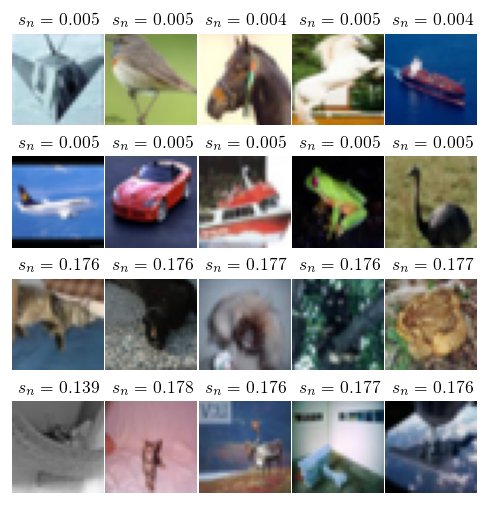

In [53]:
# PLOT PICKED OUTLIERS AND CLEAN SAMPLES
num_samples = 50
# rand_inds = np.random.choice(inds[-200:], num_samples)
cherry_picked_normal = np.array([[2928, 30883, 11953, 21925, 47091], [13598, 46433, 27421, 11588, 45245]])
cherry_picked_outliers = np.array([[9732, 3215, 8306, 28013, 7073], [12853, 19595, 33125, 20098, 37332]])

plt.figure()
fig, axs = plt.subplots(4, 5, dpi=120, figsize=(5, 5))

j=0
for i in range(5):
    ind_ = cherry_picked_normal[j, i]
    axs[j, i].imshow(to_image(train_set[0][ind_]))
    axs[j, i].set_axis_off()
    axs[j, i].set_xticklabels([])
    axs[j, i].set_yticklabels([])
    axs[j, i].set_title(f'$s_n={err[ind_]:.3f}$', fontsize = 10.5)
j=1
for i in range(5):
    ind_ = cherry_picked_normal[j, i]
    axs[j, i].imshow(to_image(train_set[0][ind_]))
    axs[j, i].set_axis_off()
    axs[j, i].set_xticklabels([])
    axs[j, i].set_yticklabels([])
    axs[j, i].set_title(f'$s_n={err[ind_]:.3f}$', fontsize = 10.5)

j=2
for i in range(5):
    ind_ = cherry_picked_outliers[j-2, i]
    axs[j, i].imshow(to_image(train_set[0][ind_]))
    axs[j, i].set_axis_off()
    axs[j, i].set_xticklabels([])
    axs[j, i].set_yticklabels([])
    axs[j, i].set_title(f'$s_n={err[ind_]:.3f}$', fontsize = 10.5)

j=3
for i in range(5):
    ind_ = cherry_picked_outliers[j-2, i]
    axs[j, i].imshow(to_image(train_set[0][ind_]))
    axs[j, i].set_axis_off()
    axs[j, i].set_xticklabels([])
    axs[j, i].set_yticklabels([])
    axs[j, i].set_title(f'$s_n={err[ind_]:.3f}$', fontsize = 10.5)


plt.subplots_adjust(wspace=0.02, hspace=0.3)
# plt.tight_layout()
plt.savefig('cifar10n_cherry_picked_clean_outliers.pdf')
plt.show()

In [ ]:
num_samples = 5
# cherry_picked_normal = np.random.choice(inds[:10000], num_samples)
# cherry_picked_outliers = np.random.choice(inds[-100:], num_samples)

# cherry_picked_normal = 13598, 46405, 27421, 11588, 45245
# cherry_picked_outliers = np.array([9732, 3215, 8306, 28013, 7073])

cherry_picked_normal = np.array([2928, 30883, 14739, 21925, 23582])
cherry_picked_outliers = np.array([40833, 19595, 33125, 20098, 37332])

normal_inds = cherry_picked_normal
outlier_inds = cherry_picked_outliers

big_image = []
for j in range(num_samples):
    big_image_row = []
    big_image_row.append(train_set[0][normal_inds[j]])
    big_image_row.append(torch.ones((3, 2, 32)))
    big_image_row.append(train_set[0][outlier_inds[j]])
    big_image.append(torch.concat(big_image_row, axis=1))
big_image = torch.concat(big_image, axis=2)

plt.figure(figsize=(10, 4))
plt.imshow(to_image(big_image))
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()
# plt.show()
plt.savefig('cifar10n_normal_vs_outlier2.png')
normal_inds, outlier_inds

In [ ]:
sns.set_style("whitegrid")

In [ ]:
# PICKING RANDOM CLEAN SAMPLES
plt.rcParams.update({
    "text.usetex": False,
})

In [ ]:
num_samples = 50
rand_inds = inds[-300:-250]
# rand_inds = inds[-num_samples:]
plt.figure(figsize=(10, 5))
fig, axs = plt.subplots(5, 10)
for j in range(5):
    for i in range(10):
        ind_ = rand_inds[j*5+i]
        axs[j, i].imshow(to_image(train_set[0][ind_]))
        axs[j, i].set_axis_off()
        axs[j, i].set_xticklabels([])
        axs[j, i].set_yticklabels([])
        axs[j,i].set_title(f'{ind_}', fontsize=9)
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.show()
print(rand_inds.reshape((5, 10)))

In [ ]:
plt.figure()
plt.imshow(to_image(train_set[0][36377]))


In [ ]:
err[normal_inds]

In [ ]:
chosen_inds = 9732, 3215, 8306, 28013, 7073

In [ ]:
outlier_inds

In [ ]:
inds

In [ ]:
num_samples = 50
rand_inds = np.random.choice(inds[:5000], num_samples)
# rand_inds = inds[-num_samples:]
plt.figure(figsize=(10, 5))
fig, axs = plt.subplots(5, 10, dpi=100)
for j in range(5):
    for i in range(10):
        axs[j, i].imshow(to_image(train_set[0][rand_inds[j*5+i]]))
        axs[j, i].set_axis_off()
        axs[j, i].set_xticklabels([])
        axs[j, i].set_yticklabels([])
        axs[j,i].set_title(f'{err[rand_inds[j*5+i]]:.3f}', fontsize=9)
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig('cifar10n_clean_examples.pdf')
plt.show()

In [ ]:
num_samples = 50
rand_inds = np.random.choice(inds[-200:], num_samples)
# rand_inds = inds[-num_samples:]
plt.figure(figsize=(10, 5))
fig, axs = plt.subplots(5, 10, dpi=100)
for j in range(5):
    for i in range(10):
        axs[j, i].imshow(to_image(train_set[0][rand_inds[j*5+i]]))
        axs[j, i].set_axis_off()
        axs[j, i].set_xticklabels([])
        axs[j, i].set_yticklabels([])
        axs[j,i].set_title(f'{err[rand_inds[j*5+i]]:.3f}', fontsize = 9)
plt.subplots_adjust(wspace=0.05, hspace=0)
# plt.tight_layout()
plt.savefig('cifar10n_outlier_examples.pdf')
plt.show()

# Plot real data result

In [ ]:
test_acc = [0.9213, 0.9064, 0.8936, 0.8621]

In [ ]:
import pandas as pd

In [ ]:

df = pd.DataFrame([['g1', 'c1', 10], ['g1', 'c2', 12], ['g1', 'c3', 13], ['g2', 'c1', 8], ['g2', 'c2', 10], ['g2', 'c3', 12]], columns=['group', 'column', 'val'])

In [ ]:
df

In [ ]:
df

In [ ]:
sns.color_palette()

In [6]:
params = {'text.usetex': False, 'font.size': 25}
plt.rcParams.update(params)

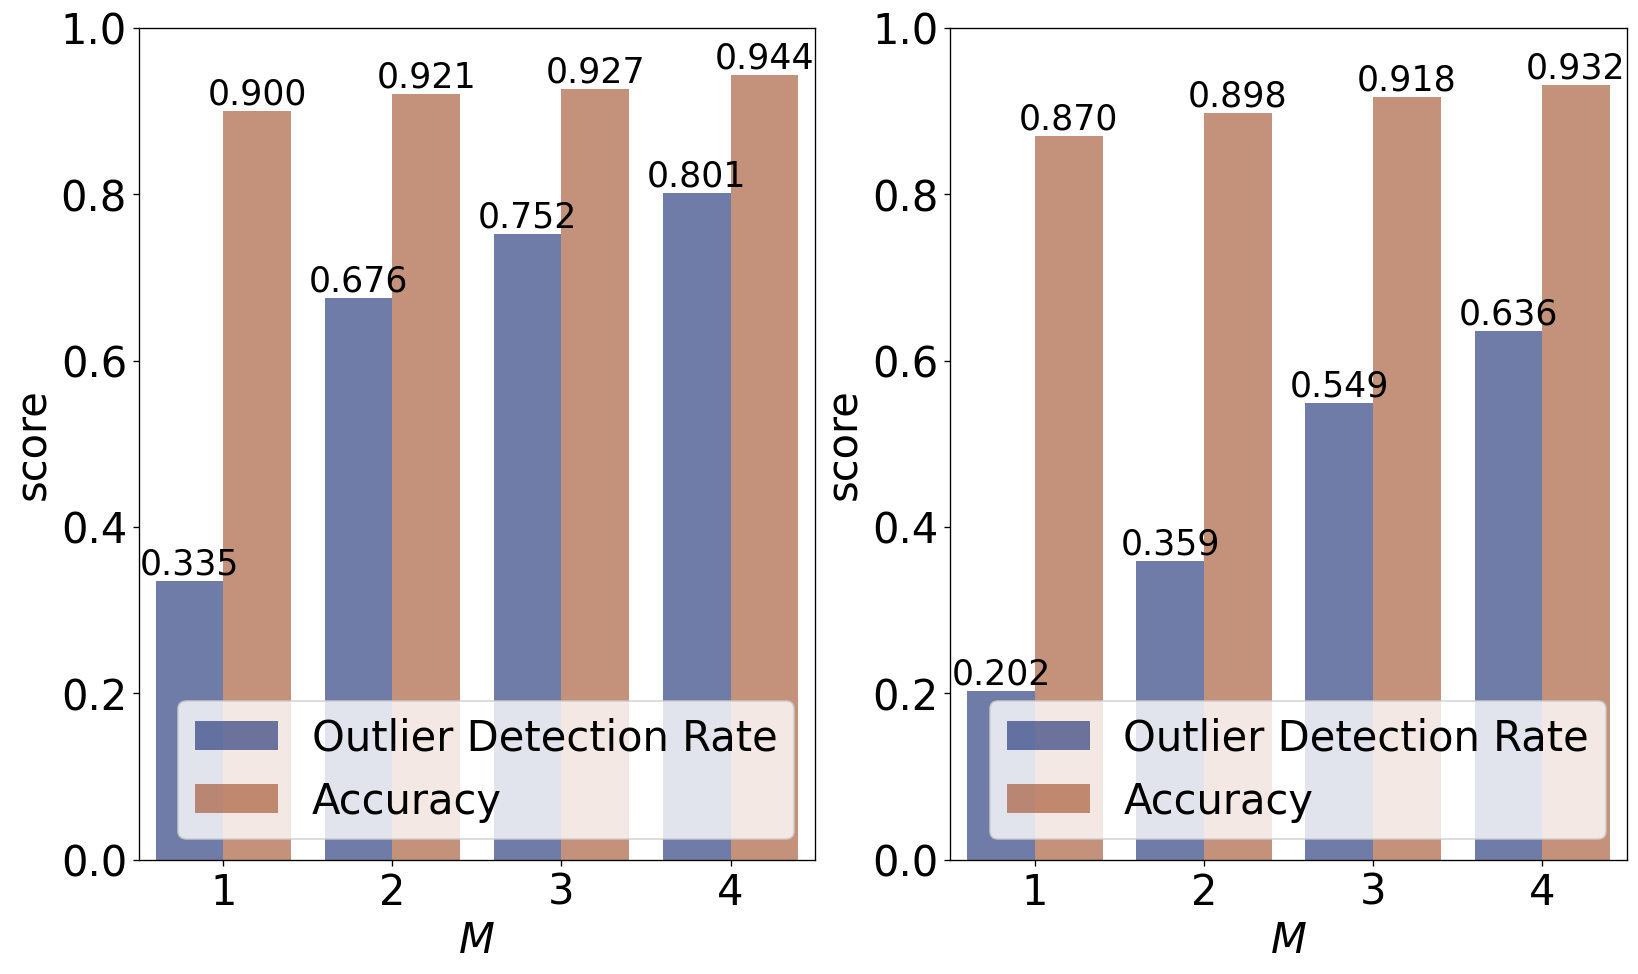

<Figure size 640x480 with 0 Axes>

In [11]:
fig, axs = plt.subplots(1, 2, dpi=120, figsize=(16,9))

# 0.2, 0.1
# 
test_acc = [0.9436, 0.9272, 0.921, 0.8999] #
outlier_detection_rate = [0.8014, 0.7521, 0.6758, 0.3349]
df = pd.DataFrame({'score': np.array(test_acc + outlier_detection_rate)[::-1]})
df['group'] = 'Accuracy'
df.loc[:3, 'group'] = 'Outlier Detection Rate'
df['M'] = [1,2,3,4,1,2,3,4]
ax = sns.barplot(data=df, x='M', y='score', hue='group', palette="dark", alpha=.6, ax=axs[0])
sns.move_legend(ax, "lower right")
ax.set_ylim(0, 1)
ax.set_xlabel('$M$')
ax.legend_.set_title(None)
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize='small')
    
    # legend = ax.legend()
    # legend.texts[0].set_text("Whatever else")
    # handles, labels = ax.get_legend_handles_labels()
    # ax.legend(handles=handles[1:], labels=labels[1:])

# 0.4, 0.1
test_acc = [0.9316, 0.9176, 0.898, 0.8704]

outlier_detection_rate = [0.6359, 0.5492, 0.3586, 0.2023]
df = pd.DataFrame({'score': np.array(test_acc + outlier_detection_rate)[::-1]})
df['group'] = 'Accuracy'
df.loc[:3, 'group'] = 'Outlier Detection Rate'
df['M'] = [1,2,3,4,1,2,3,4]
plt.figure()
ax = sns.barplot(data=df, x='M', y='score', hue='group', palette="dark", alpha=.6, ax=axs[1])
sns.move_legend(ax, "lower right")
ax.set_xlabel('$M$')
ax.set_ylim(0, 1)
ax.legend_.set_title(None)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize='small')
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[1:], labels=labels[1:])
# plt.subplots_adjust(wspace=1, hspace=5)

fig.savefig('varying_M_easy_hard.pdf')

In [ ]:
df

In [ ]:

sns.barplot(data={'M': [1,2,3,4], 'test': test_acc, 'outlier_detect': outlier_detection_rate}, x='M', y='test')

In [ ]:
flights = sns.load_dataset("flights")